In [1]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch


# import from parent level
import sys
import copy

sys.path.append("../")
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss
from utils import prepare_data
from scipy.stats import spearmanr
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
import torch.nn.functional as F
from fastshap import Surrogate, KLDivLoss
from aix360.metrics.local_metrics import faithfulness_metric
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from fastshap.image_surrogate_DP import ImageSurrogate_DP

/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %pip install python-dotenv
%load_ext dotenv
%dotenv

import torch

print(torch.cuda.device_count())

1


### Functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch


class ImageInsDel:
    def __init__(self, predict, mode, step, substrate_fn):
        r"""Create deletion/insertion metric instance.

        Args:
            predict (func): function that takes in input a numpy array and return the prediction.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ["del", "ins"]
        self.predict = predict
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn

    def __call__(self, img, size, explanation, rgb=True, verbose=0, save_to=None):
        r"""Run metric on one image-saliency pair.

        Args:
            img (np.ndarray): normalized image tensor.
            size (int): size of the image ex:224
            explanation (np.ndarray): saliency map.
            rgb (bool): if the image is rgb or grayscale
            verbose (int): in [0, 1, 2].
                0 - return list of scores.
                1 - also plot final step.
                2 - also plot every step and print 2 top classes.
            save_to (str): directory to save every step plots to.

        Return:
            scores (nd.array): Array containing scores at every step.
        """
        if rgb:
            CH = 3
        else:
            CH = 1
        HW = size * size  # image area
        pred = torch.tensor(self.predict(img))
        top, c = torch.max(pred, 1)
        c = c[0]
        n_steps = (HW + self.step - 1) // self.step

        if self.mode == "del":
            title = "Deletion metric"
            ylabel = "Pixels deleted"
            start = torch.tensor(img).clone()
            finish = self.substrate_fn(torch.tensor(img))
        elif self.mode == "ins":
            title = "Insertion metric"
            ylabel = "Pixels inserted"
            start = self.substrate_fn(torch.tensor(img))
            finish = torch.tensor(img).clone()

        scores = np.empty(n_steps + 1)
        # Coordinates of pixels in order of decreasing saliency
        salient_order = np.flip(
            np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1
        )
        for i in range(n_steps + 1):
            pred = torch.tensor(self.predict(start).softmax(dim=1))
            pr, cl = torch.topk(pred, 2)
            if verbose == 2:
                print("class {}: probability {:.3f}".format(cl[0][0], float(pr[0][0])))
                print("class {}: probability {:.3f}".format(cl[0][1], float(pr[0][1])))
            scores[i] = pred[0, c]
            # Render image if verbose, if it's the last step or if save is required.
            if verbose == 2 or (verbose == 1 and i == n_steps) or save_to:
                plt.figure(figsize=(10, 5))
                plt.subplot(121)
                plt.title(
                    "{} {:.1f}%, P={:.4f}".format(ylabel, 100 * i / n_steps, scores[i])
                )
                plt.axis("off")
                # tensor_imshow(start[0])
                image = (start[0].detach().cpu().numpy()).astype(int)
                if rgb:
                    plt.imshow(
                        np.stack(
                            [image[0, :, :], image[1, :, :], image[2, :, :]], axis=-1
                        )
                    )
                else:
                    plt.imshow(image[0], cmap="gray")

                plt.subplot(122)
                plt.plot(np.arange(i + 1) / n_steps, scores[: i + 1])
                plt.xlim(-0.1, 1.1)
                plt.ylim(0, 1.05)
                plt.fill_between(
                    np.arange(i + 1) / n_steps, 0, scores[: i + 1], alpha=0.4
                )
                plt.title(title)
                plt.xlabel(ylabel)
                # plt.ylabel(get_class_name(c))
                if save_to:
                    plt.savefig(save_to + "/{:03d}.png".format(i))
                    plt.close()
                else:
                    plt.show()
            if i < n_steps:
                coords = salient_order[:, self.step * i : self.step * (i + 1)]
                start.cpu().numpy().reshape(1, CH, HW)[0, :, coords] = (
                    finish.cpu().numpy().reshape(1, CH, HW)[0, :, coords]
                )
        return scores

In [4]:
# Faithfulness evaluation
class aix_model:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x):
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.exp(self.model(x)).detach().numpy()


def compute_faithfulness(x, y, fastshap_explanation, model, base_value=0.2):
    x = x[0]
    fastshap_explanation = np.array(torch.tensor(fastshap_explanation).cpu())

    faithfulness = faithfulness_metric(
        model=model,
        x=np.array(x),
        coefs=fastshap_explanation,
        base=base_value * np.ones(shape=fastshap_explanation.shape[0]),
    )
    return faithfulness


def process_explainer(
    explanation_file_name, explainer, model, x, y, index, base_value, base_path
):
    if not os.path.isfile(
        f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
    ):
        fastshap_explanation = explainer.shap_values(x)
        fastshap_explanation = fastshap_explanation[0]  # [:, y]
        torch.save(
            fastshap_explanation,
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt",
        )
    else:
        fastshap_explanation = torch.load(
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
        )

    # if not os.path.isfile(
    #     f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
    # ):
    #     faithfulness = compute_faithfulness(
    #         x,
    #         y,
    #         fastshap_explanation,
    #         model,
    #         base_value=base_value,
    #     )
    #     torch.save(
    #         faithfulness,
    #         f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt",
    #     )
    # else:
    #     faithfulness = torch.load(
    #         f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
    #     )
    return fastshap_explanation  # , faithfulness

In [5]:
class Args:
    def __init__(self):
        self.dataset_name = "mnist"
        self.sweep = True


args = Args()
args.seed = 42
args.sweep = False
args.dataset_name = "mnist"
(
    train_set,
    val_set,
    test_set,
) = prepare_data(args)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        output = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return output

In [6]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_eps_05,
    faithfulness_eps_1,
    faithfulness_eps_2,
    faithfulness_eps_3,
    faithfulness_eps_4,
    faithfulness_eps_5,
    faithfulness_eps_10,
    faithfulness_eps_100,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = sem(faithfulness_no_dp)

    mean_eps_05 = np.mean(faithfulness_eps_05)
    std_eps_05 = sem(faithfulness_eps_05)

    mean_eps_1 = np.mean(faithfulness_eps_1)
    std_eps_1 = sem(faithfulness_eps_1)

    mean_eps_2 = np.mean(faithfulness_eps_2)
    std_eps_2 = sem(faithfulness_eps_2)

    mean_eps_3 = np.mean(faithfulness_eps_3)
    std_eps_3 = sem(faithfulness_eps_3)

    mean_eps_4 = np.mean(faithfulness_eps_4)
    std_eps_4 = sem(faithfulness_eps_4)

    mean_eps_5 = np.mean(faithfulness_eps_5)
    std_eps_5 = sem(faithfulness_eps_5)

    mean_eps_10 = np.mean(faithfulness_eps_10)
    std_eps_10 = sem(faithfulness_eps_10)

    mean_eps_100 = np.mean(faithfulness_eps_100)
    std_eps_100 = sem(faithfulness_eps_100)

    results_mean = {
        "No DP": [mean_no_dp],
        # "Eps. 05": [mean_eps_05],
        "Eps. 1": [mean_eps_1],
        "Eps. 2": [mean_eps_2],
        "Eps. 3": [mean_eps_3],
        "Eps. 4": [mean_eps_4],
        "Eps. 5": [mean_eps_5],
        # "Eps. 10": [mean_eps_10],
        # "Eps. 100": [mean_eps_100],
    }

    results_std = {
        "No DP": [std_no_dp],
        # "Eps. 05": [std_eps_05],
        "Eps. 1": [std_eps_1],
        "Eps. 2": [std_eps_2],
        "Eps. 3": [std_eps_3],
        "Eps. 4": [std_eps_4],
        "Eps. 5": [std_eps_5],
        # "Eps. 10": [std_eps_10],
        # "Eps. 100": [std_eps_100],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()


def plot_error_bar(labels, results_mean, results_std, y_label, title, y_lim=None):
    means = [results_mean[label] for label in labels]
    errors = [results_std[label] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel(y_label, fontsize=14)
    plt.title(
        title,
        fontsize=16,
    )
    # y lim
    if y_lim:
        plt.ylim(y_lim)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.xticks(rotation=90)

    plt.show()

In [7]:
from explainer_architecture import UNet


def load_data(
    private_model: bool,
    private_surrogate: bool,
    explainer_privacy_levels: list,
    base_path: str,
    model_name: str,
    surrogate_name: str,
    explainer_name: str,
    device: str,
    eps_bb: str = "",
):
    loaded_data = {}
    loaded_data["private_model"] = private_model
    loaded_data["private_surrogate"] = private_surrogate
    private_model_str = "private_model_" if private_model else ""

    if os.path.isfile(
        f"{base_path}bb/{model_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pth"
    ):
        print(
            "Loading saved model from: ",
            f"{base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth",
        )
        model = torch.load(
            f"{base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        ).to("cpu")
        model_aix = aix_model(model)

    # Surrogate model without DP
    if os.path.isfile(
        f"{base_path}/surrogate/{surrogate_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pt"
    ):
        print(
            "Loading saved surrogate model: ",
            f"{base_path}/surrogate/{surrogate_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pt",
        )
        surr = torch.load(
            f"{base_path}/surrogate/{surrogate_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pt"
        ).to(device)
        surrogate = ImageSurrogate_DP(surr, width=28, height=28, superpixel_size=2)

    loaded_data["model"] = model
    loaded_data["model_aix"] = model_aix
    loaded_data["surrogate"] = surrogate

    for eps in explainer_privacy_levels:
        if os.path.isfile(
            f"{base_path}/explainer/{explainer_name}_"
            + ("private_model_" if private_model else "")
            + f"{eps}.pth"
        ):
            print(
                "Loading saved explainer model: ",
                f"{base_path}/explainer/{explainer_name}_"
                + ("private_model_" if private_model else "")
                + f"{eps}.pth",
            )

            def load_checkpoint(filepath, model, optimizer=None):
                checkpoint = torch.load(filepath)
                model.load_state_dict(checkpoint["state_dict"], strict=False)
                if optimizer and "optimizer" in checkpoint:
                    optimizer.load_state_dict(checkpoint["optimizer"])
                return model

            # Usage example:
            model = UNet(
                n_classes=10,
                num_down=2,
                num_up=1,
                num_convs=3,
                in_channels=1,
                base_channels=8,
                bilinear=False,
            )  # Initialize your model architecture first
            optimizer = torch.optim.Adam(
                model.parameters()
            )  # Initialize optimizer if needed
            explainer = load_checkpoint(
                f"{base_path}/explainer/{explainer_name}_"
                + ("private_model_" if private_model else "")
                + f"{eps}.pth",
                model,
                optimizer,
            ).to(device)

            # explainer = torch.load(
            # f"{base_path}/explainer/{explainer_name}_"
            # + ("private_model_" if private_model else "")
            # + f"{eps}.pth"
            # ).to(device)
            fastshap = FastSHAP(
                explainer, surrogate, normalization="none", link=nn.Softmax(dim=-1)
            )
            loaded_data[f"explainer_{eps}"] = fastshap
        else:
            print(
                f"Explainer model not found:"
                + f"{base_path}/explainer/{explainer_name}_"
                + ("private_model_" if private_model else "")
                + f"{eps}.pth"
            )
    return loaded_data

In [8]:
def get_explanations(
    model_predictions: list, X_test, loaded_data: dict, base_value: float
):
    for privacy_level in explainer_privacy_levels:
        faithfulness = []
        explanations = []
        for index, (x, y) in enumerate(zip(X_test, model_predictions)):
            # y = 0 if not y else 1
            x = x[0]

            shap_NO_DP = process_explainer(
                f"private_model_{loaded_data['private_model']}_surrogate_{loaded_data['private_surrogate']}_explainer_{privacy_level}",
                loaded_data[f"explainer_{privacy_level}"],
                loaded_data["model_aix"],
                x,
                y,
                index,
                base_value,
                base_path="../artifacts/mnist/",
            )
            explanations.append(copy.deepcopy(shap_NO_DP))
            # faithfulness.append(faithfulness_NO_DP)
            loaded_data[f"explanations_{privacy_level}"] = explanations
            loaded_data[f"faithfulness_{privacy_level}"] = faithfulness

In [9]:
def plot_base_explainer_shap_values(
    loaded_data, explainer_privacy_levels, X_test, feature_names, title
):
    explanations = []
    for index in range(len(X_test)):
        fastshap_NO_DP = loaded_data["explanations_NO_DP"][index]
        # compute the absolute values of the shap values
        fastshap_NO_DP = np.abs(fastshap_NO_DP)
        explanations.append(fastshap_NO_DP)

    # mean of the absolute values of the shap values
    mean_explanations = np.mean(explanations, axis=0)
    # sort the mean_explanations and the corresponding feature names
    sorted_indices = np.argsort(mean_explanations)[::-1]
    print(len(sorted_indices))
    print(len(feature_names))
    # plot the mean shap values with the corresponding feature names in sorted indices
    plt.figure(figsize=(10, 6))
    plt.bar(
        [feature_names[i] for i in sorted_indices], mean_explanations[sorted_indices]
    )
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Mean SHAP Value")
    plt.title(title)
    plt.show()

In [10]:
def create_dictionaries_metrics(explainer_privacy_levels, metrics, current_metric):
    mean = {}
    std = {}
    for privacy_level in explainer_privacy_levels:
        mean["Epsilon " + privacy_level.split("_")[1]] = np.mean(
            metrics[current_metric + privacy_level]
        )
        std["Epsilon " + privacy_level.split("_")[1]] = sem(
            metrics[current_metric + privacy_level]
        )
    return mean, std

### Load Data

In [11]:
explainer_privacy_levels = [
    "NO_DP",
    "DP_1",
    "DP_2",
    # "DP_3",
    # "DP_4",
    "DP_5",
    "DP_10",
    # "DP_100",
]

loaded_data_private_model = load_data(
    private_model=True,
    private_surrogate=True,
    explainer_privacy_levels=explainer_privacy_levels,
    base_path="../artifacts/mnist/",
    model_name="bb_mnist",
    surrogate_name="mnist_surrogate",
    explainer_name="mnist_explainer",
    device="cuda",
    eps_bb="DP_1",
)

loaded_data_NO_DP_bb = load_data(
    private_model=False,
    private_surrogate=False,
    explainer_privacy_levels=explainer_privacy_levels,
    base_path="../artifacts/mnist/",
    model_name="bb_mnist",
    surrogate_name="mnist_surrogate",
    explainer_name="mnist_explainer",
    device="cuda",
)

Loading saved model from:  ../artifacts/mnist/bb/bb_mnist_DP_1.pth


/tmp/ipykernel_3250293/162865681.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(


Loading saved surrogate model:  ../artifacts/mnist//surrogate/mnist_surrogate_DP_1.pt
Explainer model not found:../artifacts/mnist//explainer/mnist_explainer_private_model_NO_DP.pth
Explainer model not found:../artifacts/mnist//explainer/mnist_explainer_private_model_DP_1.pth
Explainer model not found:../artifacts/mnist//explainer/mnist_explainer_private_model_DP_2.pth
Explainer model not found:../artifacts/mnist//explainer/mnist_explainer_private_model_DP_5.pth
Explainer model not found:../artifacts/mnist//explainer/mnist_explainer_private_model_DP_10.pth
Loading saved model from:  ../artifacts/mnist/bb/bb_mnist_NO_DP.pth


/tmp/ipykernel_3250293/162865681.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  surr = torch.load(


Loading saved surrogate model:  ../artifacts/mnist//surrogate/mnist_surrogate_NO_DP.pt
Loading saved explainer model:  ../artifacts/mnist//explainer/mnist_explainer_NO_DP.pth
Loading saved explainer model:  ../artifacts/mnist//explainer/mnist_explainer_DP_1.pth
Loading saved explainer model:  ../artifacts/mnist//explainer/mnist_explainer_DP_2.pth
Loading saved explainer model:  ../artifacts/mnist//explainer/mnist_explainer_DP_5.pth


/tmp/ipykernel_3250293/162865681.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Loading saved explainer model:  ../artifacts/mnist//explainer/mnist_explainer_DP_10.pth


## Make Predictions

In [12]:
from torch.utils.data import (
    DataLoader,
)

test_loader = (
    DataLoader(test_set, batch_size=128, shuffle=False)
    if test_set is not None
    else None
)


def get_model_predictions(model):
    model_predictions = []
    for x, label in test_loader:
        model_prediction = model(x)
        model_prediction = model_prediction.argmax(dim=1)
        model_predictions.extend(model_prediction)

    model_predictions = [
        model_predictions[i].item() for i in range(len(model_predictions))
    ]
    return model_predictions


# loaded_data_private_model["model_predictions"] = get_model_predictions(
#     model=loaded_data_private_model["model"]
# )
loaded_data_NO_DP_bb["model_predictions"] = get_model_predictions(
    model=loaded_data_NO_DP_bb["model"]
)

/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


## Compute Explanations

In [13]:
# get_explanations(
#     model_predictions=loaded_data_private_model["model_predictions"],
#     X_test=test_loader,
#     loaded_data=loaded_data_private_model,
#     base_value=0.2,
# )

get_explanations(
    model_predictions=loaded_data_NO_DP_bb["model_predictions"],
    X_test=test_loader,
    loaded_data=loaded_data_NO_DP_bb,
    base_value=0.2,
)

/tmp/ipykernel_3250293/656430357.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fastshap_explanation = torch.load(


## Compute Metrics

In [14]:
# feature_names.append("bias")
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_private_model,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for Private Model",
# )

In [15]:
# top_k_private_BB = [
#     "edu_level",
#     "sex_binary",
#     "economic_status",
#     "age",
# ]

In [16]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_NO_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
# )

In [17]:
# top_k_non_private_bb = [
#     "edu_level",
#     "sex_binary",
#     "age",
#     "economic_status",
# ]

# Images


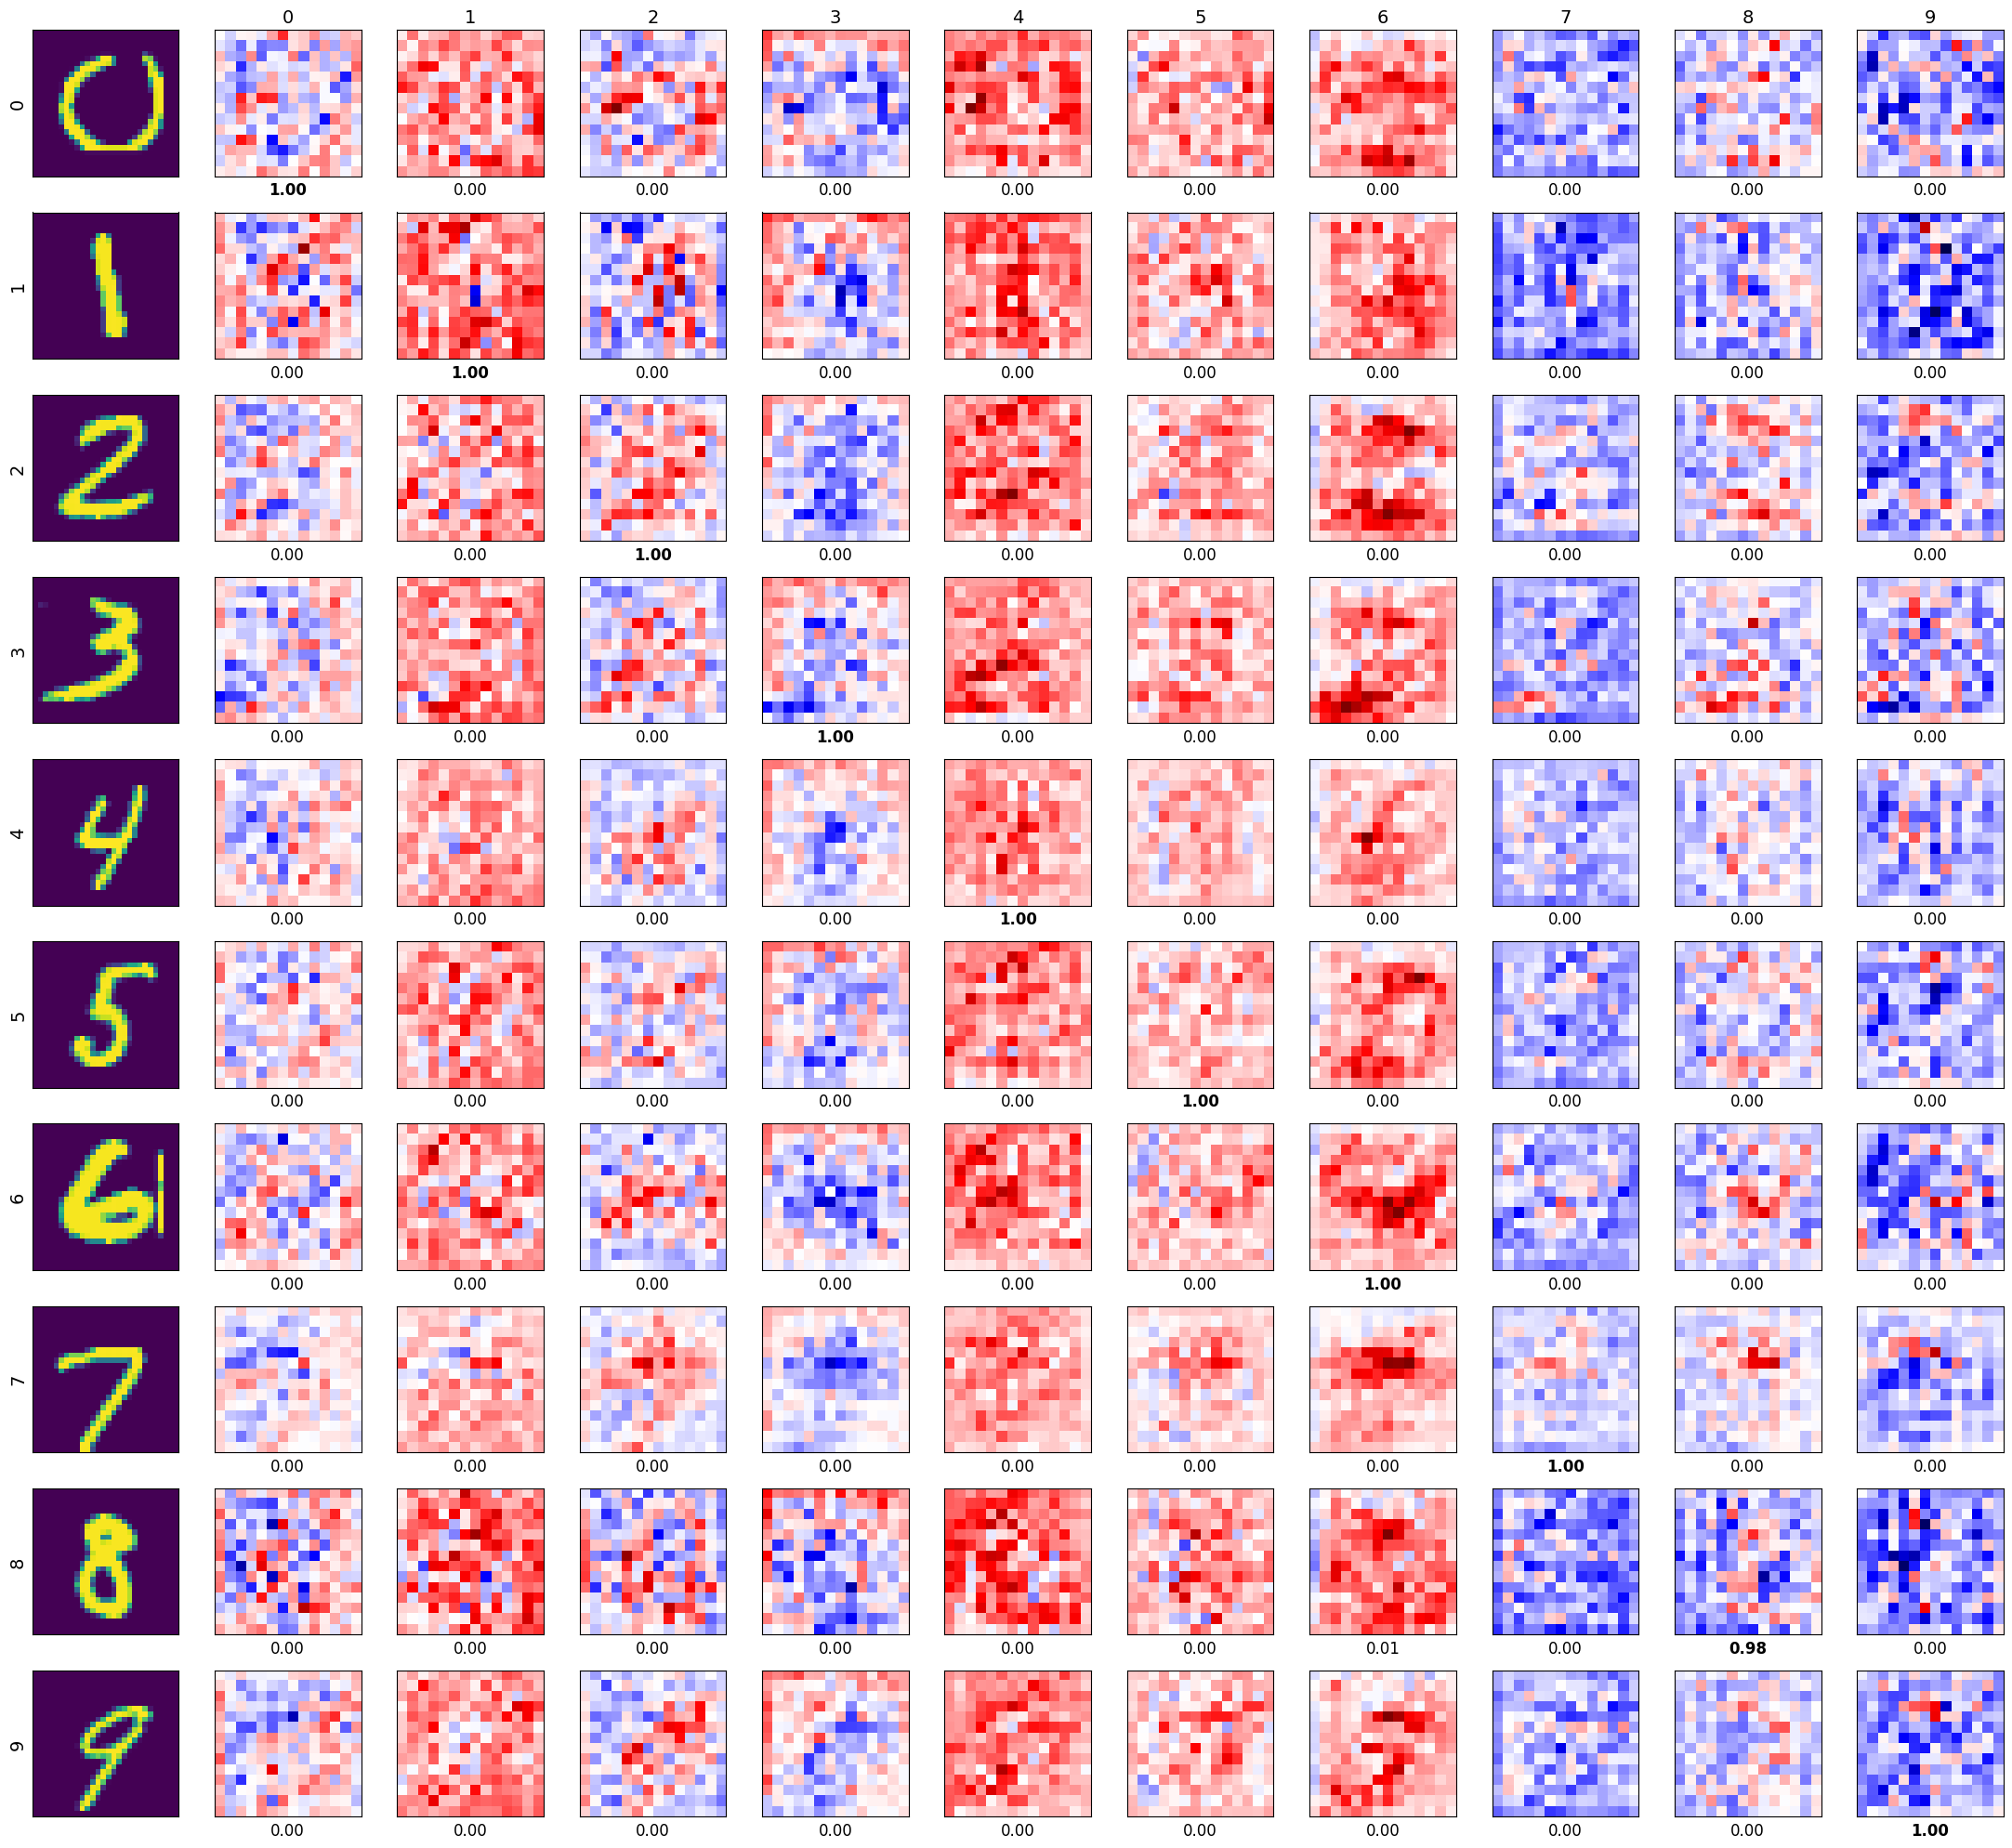

In [53]:
# Select one image from each class
dset = test_set
targets = np.array(test_set.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
# print(inds)
inds = [380, 3866, 4710, 7024, 7009, 5020, 8116, 6640, 3987, 9767]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
# values = loaded_data_NO_DP_bb["explainer_NO_DP"].shap_values(x.to("cuda"))
values = loaded_data_NO_DP_bb["explainer_NO_DP"].shap_values(x.to("cuda"))

# Get predictions
pred = (
    loaded_data_NO_DP_bb["surrogate"](
        x.to("cuda"),
        torch.ones(
            num_classes,
            loaded_data_NO_DP_bb["surrogate"].num_players,
            device="cuda",
        ),
    )
    .softmax(dim=1)
    .cpu()
    .data.numpy()
)

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
    ]
    mean = np.array([0.1307])[:, np.newaxis, np.newaxis]
    std = np.array([0.3081])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel("{}".format(classes[y[row]]), fontsize=14)

    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap="seismic", vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel(
                "{:.2f}".format(pred[row, col]), fontsize=12, fontweight="bold"
            )
        else:
            axarr[row, col + 1].set_xlabel("{:.2f}".format(pred[row, col]), fontsize=12)

        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title("{}".format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.savefig("mnist_explanations.png")

plt.show()

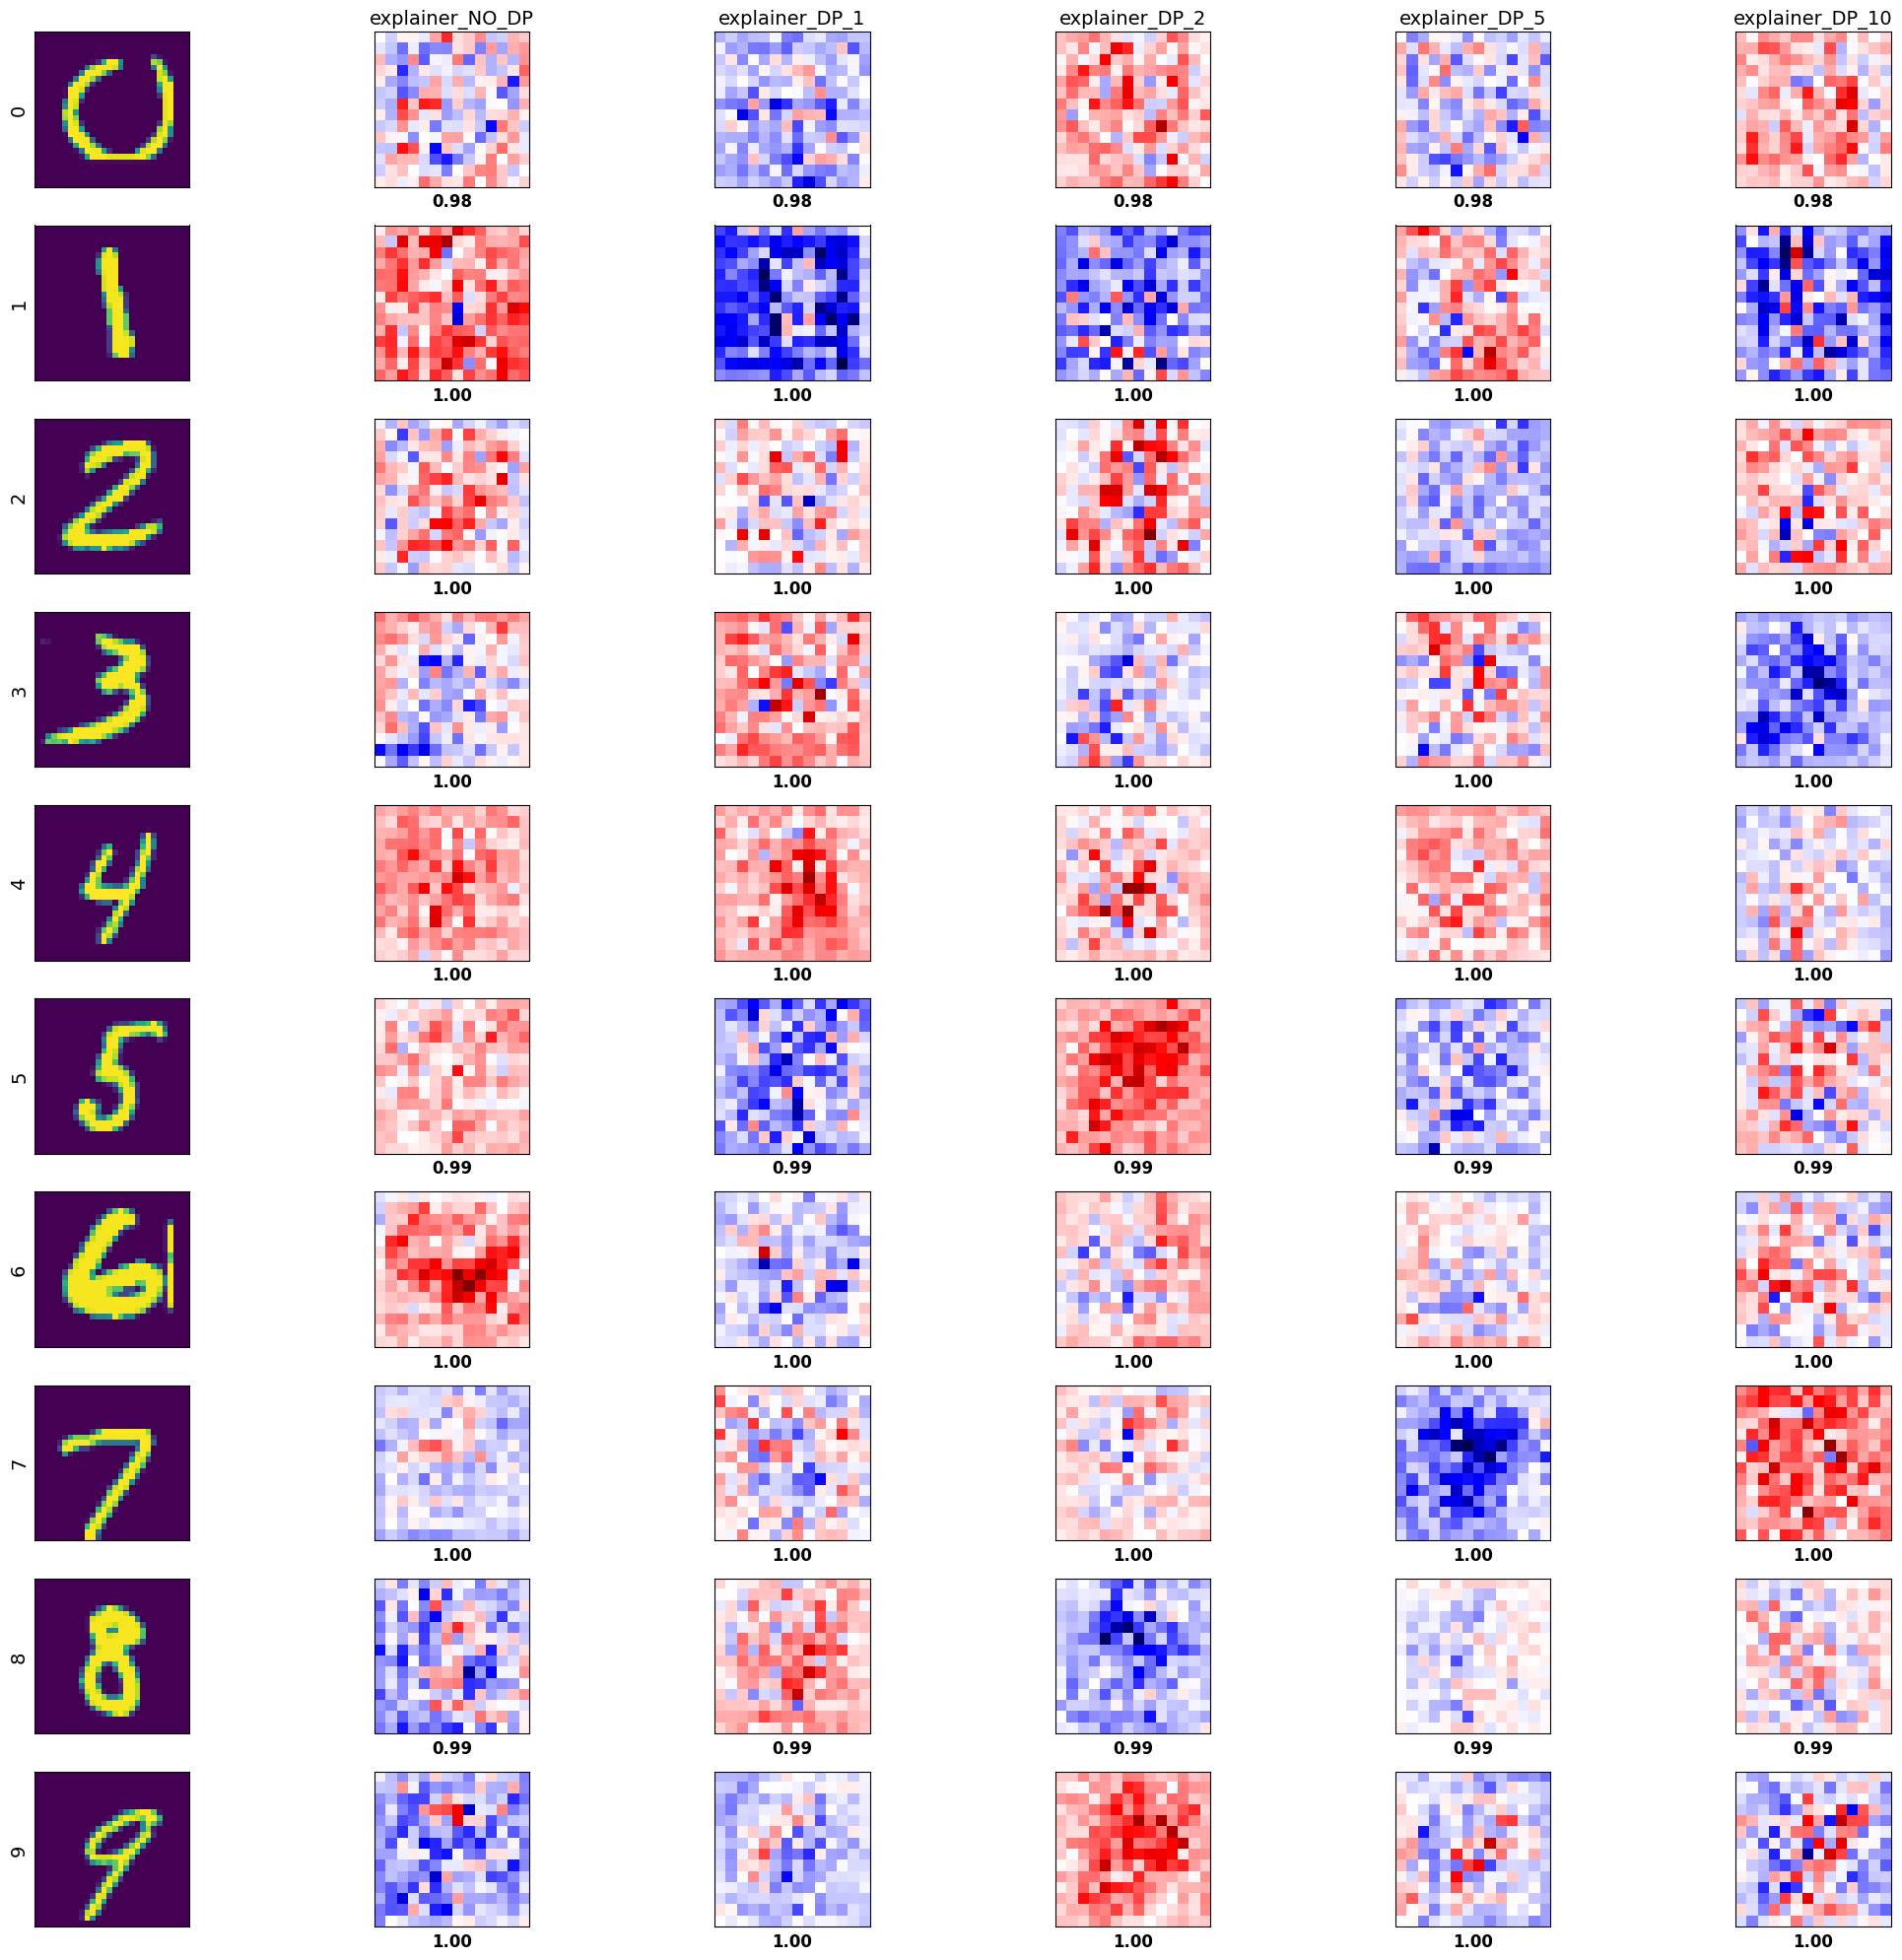

In [63]:
# Select one image from each class
dset = test_set
targets = np.array(test_set.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
# inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
inds = [380, 3866, 4710, 7024, 7009, 5020, 8116, 6640, 3987, 9767]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Define the explainers you want to compare
explainers = [
    "explainer_NO_DP",
    "explainer_DP_1",
    "explainer_DP_2",
    "explainer_DP_5",
    "explainer_DP_10",
]

# Get explanations and predictions for each explainer
explanations = {}
predictions = {}
model = loaded_data_private_model["model"].to("cuda")
pred = (
    model(
        x.to("cuda"),
    )
    .softmax(dim=1)
    .cpu()
    .data.numpy()
)
for explainer in explainers:
    values = loaded_data_NO_DP_bb[explainer].shap_values(x.to("cuda"))

    explanations[explainer] = values
    predictions[explainer] = pred

fig, axarr = plt.subplots(num_classes, len(explainers) + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
    ]
    mean = np.array([0.1307])[:, np.newaxis, np.newaxis]
    std = np.array([0.3081])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel("{}".format(classes[y[row]]), fontsize=14)

    # Explanations for each explainer
    for col, explainer in enumerate(explainers):
        m = np.abs(explanations[explainer][row]).max()
        predicted_class = predictions[explainer][row].argmax()

        axarr[row, col + 1].imshow(
            explanations[explainer][row, predicted_class],
            cmap="seismic",
            vmin=-m,
            vmax=m,
        )
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        axarr[row, col + 1].set_xlabel(
            "{:.2f}".format(predictions[explainer][row, predicted_class]),
            fontsize=12,
            fontweight="bold",
        )

        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title("{}".format(explainer), fontsize=14)

plt.tight_layout()
plt.savefig("mnist_explanations_comparison.png")

plt.show()

In [20]:
# similarità immagini

# structured similarity index (SSIM)
# SIFT
# HOG (Histogram of Oriented Gradients)
# LBP (Local Binary Patterns)

In [21]:
loaded_data_private_model["model"]

GradSampleModule(SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
))

In [22]:
# # Select one image from each class
# dset = test_set
# targets = np.array(test_set.targets)
# num_classes = targets.max() + 1
# inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
# inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
# x, y = zip(*[dset[ind] for ind in inds])
# x = torch.stack(x)

# # Define the explainers you want to compare
# explainers = [
#     "explainer_NO_DP",
#     "explainer_DP_1",
#     "explainer_DP_2",
#     "explainer_DP_3",
#     "explainer_DP_4",
#     "explainer_DP_5",
#     "explainer_DP_10",
#     "explainer_DP_100",
# ]

# # Get explanations and predictions for each explainer
# explanations = {}
# predictions = {}
# # Move the model to the GPU
# model = loaded_data_private_model["model"].to("cuda")

# pred = (
#     model(
#         x.to("cuda"),
#     )
#     .softmax(dim=1)
#     .cpu()
#     .data.numpy()
# )
# for explainer in explainers:
#     values = loaded_data_private_model[explainer].shap_values(x.to("cuda"))

#     explanations[explainer] = values
#     predictions[explainer] = pred

# fig, axarr = plt.subplots(num_classes, len(explainers) + 1, figsize=(22, 20))

# for row in range(num_classes):
#     # Image
#     classes = [
#         "0",
#         "1",
#         "2",
#         "3",
#         "4",
#         "5",
#         "6",
#         "7",
#         "8",
#         "9",
#     ]
#     mean = np.array([0.1307, 0.1307, 0.1307])[:, np.newaxis, np.newaxis]
#     std = np.array([0.3081, 0.3081, 0.3081])[:, np.newaxis, np.newaxis]
#     im = x[row].numpy() * std + mean
#     im = im.transpose(1, 2, 0).astype(float)
#     im = np.clip(im, a_min=0, a_max=1)
#     axarr[row, 0].imshow(im, vmin=0, vmax=1)
#     axarr[row, 0].set_xticks([])
#     axarr[row, 0].set_yticks([])
#     axarr[row, 0].set_ylabel("{}".format(classes[y[row]]), fontsize=14)

#     # Explanations for each explainer
#     for col, explainer in enumerate(explainers):
#         m = np.abs(explanations[explainer][row]).max()
#         predicted_class = predictions[explainer][row].argmax()
#         axarr[row, col + 1].imshow(
#             explanations[explainer][row, predicted_class],
#             cmap="seismic",
#             vmin=-m,
#             vmax=m,
#         )
#         axarr[row, col + 1].set_xticks([])
#         axarr[row, col + 1].set_yticks([])
#         axarr[row, col + 1].set_xlabel(
#             "{:.2f}".format(predictions[explainer][row, predicted_class]),
#             fontsize=12,
#             fontweight="bold",
#         )

#         # Class labels
#         if row == 0:
#             axarr[row, col + 1].set_title("{}".format(explainer), fontsize=14)

# plt.tight_layout()
# plt.savefig("mnist_explanations_comparison.png")

# plt.show()

## Compute metrics

In [23]:
def compute_metrics(X_test, loaded_data, explainer_privacy_levels):
    metrics = {}
    predictions = loaded_data["model_predictions"]
    for privacy_level in explainer_privacy_levels:
        L2_distances = []
        spearman_correlation = []
        cosine_similarity = []
        kendall_tau = []

        for index, pred in zip(range(len(X_test)), predictions):
            explanation_NO_DP = torch.tensor(
                loaded_data["explanations_NO_DP"][index][pred]
            ).flatten()
            # convert to numpy array
            explanation_NO_DP = explanation_NO_DP.detach().numpy()

            explanation_DP = torch.tensor(
                loaded_data[f"explanations_{privacy_level}"][index][pred]
            ).flatten()

            explanation_DP = explanation_DP.detach().numpy()

            L2_distances.append(np.linalg.norm(explanation_NO_DP - explanation_DP))
            coef, p = spearmanr(explanation_DP, explanation_NO_DP)
            spearman_correlation.append(coef)
            cosine_similarity.append(
                np.dot(explanation_DP, explanation_NO_DP)
                / (np.linalg.norm(explanation_DP) * np.linalg.norm(explanation_NO_DP))
            )
            tau, p_value = kendalltau(explanation_DP, explanation_NO_DP)
            kendall_tau.append(tau)

        metrics[f"L2_{privacy_level}"] = L2_distances
        metrics[f"spearman_{privacy_level}"] = spearman_correlation
        metrics[f"cosine_{privacy_level}"] = cosine_similarity
        metrics[f"kendall_{privacy_level}"] = kendall_tau
    return metrics

In [24]:
metrics_NO_DP_bb = compute_metrics(
    test_loader,
    loaded_data_NO_DP_bb,
    explainer_privacy_levels,
)

In [25]:
# metrics_private_BB = compute_metrics(
#     test_loader,
#     loaded_data_private_model,
#     explainer_privacy_levels,
# )

## Inclusion and exclusion

In [26]:
inds = [0]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

In [27]:
loaded_data_NO_DP_bb["model"](x)

tensor([[ -6.1640,   0.2087,   1.0374,   3.2620,  -0.4718,  -7.1760, -13.9448,
          21.8246,  -7.3744,   3.3873]], grad_fn=<AddmmBackward0>)

In [28]:
loaded_data_NO_DP_bb["model"].to("cpu")
pred = (
    loaded_data_NO_DP_bb["model"](
        x.to("cpu"),
    )
    .argmax(dim=1)
    .cpu()
    .data.numpy()
)

In [29]:
pred

array([7])

In [30]:
explanation = loaded_data_NO_DP_bb["explanations_NO_DP"][0][7]

In [31]:
explanation.shape

(14, 14)

In [32]:
x.shape

torch.Size([1, 1, 28, 28])

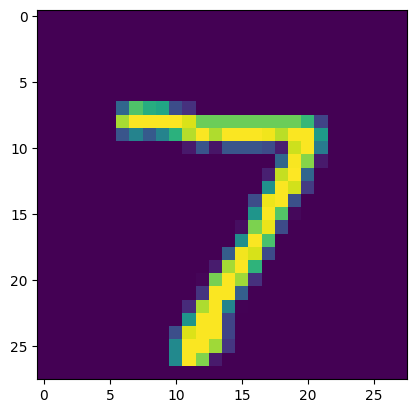

In [33]:
plt.imshow(
    x[0][0],
)

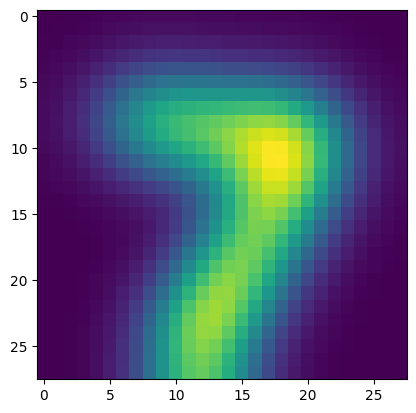

In [34]:
from scipy.ndimage import gaussian_filter

blurred = gaussian_filter(x, sigma=3)

blurred.shape

plt.imshow(
    blurred[0][0],
)

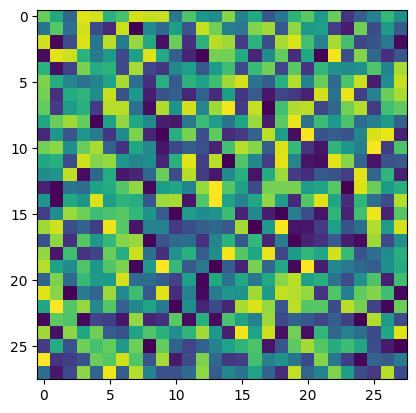

In [35]:
# Instead of a blurred image, we want to use a random image

random_image = torch.rand_like(x)

random_image.shape

plt.imshow(
    random_image[0][0],
)

In [36]:
def compute_insert_and_delete(
    step,
    predict,
    substrate_fn,
    explanations,
    test_data,
    image_size,
    explainer_name,
):
    ins_total = []
    del_total = []

    for index in range(len(test_data)):
        inds = [index]
        x, y = zip(*[dset[ind] for ind in inds])
        x = torch.stack(x)

        pred = predict(x.to("cpu")).argmax(dim=1).cpu().data.numpy()
        explanation = loaded_data_NO_DP_bb[explainer_name][0][pred]
        new_explanation = np.repeat(explanation, 2, axis=0)
        new_explanation = np.repeat(new_explanation, 2, axis=1)

        ins_ = ImageInsDel(
            predict=predict,
            mode="ins",
            step=step,
            # return the blurred image
            substrate_fn=substrate_fn,
        )

        ins_total.append(ins_(x, image_size, new_explanation, rgb=False, verbose=0))

        del_ = ImageInsDel(
            predict=predict,
            mode="del",
            step=step,
            # return the blurred image
            substrate_fn=substrate_fn,
        )

        del_total.append(del_(x, image_size, new_explanation, rgb=False, verbose=0))

    return (
        np.mean(ins_total, axis=0),
        sem(ins_total, axis=0),
        np.mean(del_total, axis=0),
        sem(del_total, axis=0),
    )

In [37]:
insert_dict = {}
delete_dict = {}

for explainer_name in [
    "explanations_NO_DP",
    "explanations_DP_1",
    "explanations_DP_2",
    # "explanations_DP_3",
    # "explanations_DP_4",
    "explanations_DP_5",
    "explanations_DP_10",
]:
    insertion_avg, insertion_std, deletion_avg, deletion_std = (
        compute_insert_and_delete(
            step=50,
            predict=loaded_data_NO_DP_bb["model"],
            substrate_fn=lambda z: torch.tensor(
                gaussian_filter(z, sigma=3)
            ),  # provare nero
            explanations=loaded_data_NO_DP_bb[explainer_name],
            test_data=test_loader,
            image_size=28,
            explainer_name=explainer_name,
        )
    )

    insert_dict[explainer_name] = insertion_avg
    insert_dict[explainer_name + "_std"] = insertion_std
    delete_dict[explainer_name] = deletion_avg
    delete_dict[explainer_name + "_std"] = deletion_std

# plot the list of values in the insert_dict and delete_dict
# the values are in the form [0.1, 0.3, 0.5, 0.7, 0.9] on the x axis I want either "Pixel inserted" or "Pixel deleted"
# on the y axis I want the value of the insertion or deletion.

/tmp/ipykernel_3250293/3795098234.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(img))
/tmp/ipykernel_3250293/3795098234.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start = self.substrate_fn(torch.tensor(img))
/tmp/ipykernel_3250293/3795098234.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  finish = torch.tensor(img).clone()
/tmp/ipykernel_3250293/3795098234.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone(

In [38]:
insert_dict.keys()

dict_keys(['explanations_NO_DP', 'explanations_NO_DP_std', 'explanations_DP_1', 'explanations_DP_1_std', 'explanations_DP_2', 'explanations_DP_2_std', 'explanations_DP_5', 'explanations_DP_5_std', 'explanations_DP_10', 'explanations_DP_10_std'])

In [39]:
insert_dict["explanations_NO_DP"]

array([0.16974644, 0.24805109, 0.37064645, 0.50422654, 0.59397877,
       0.68771348, 0.80453896, 0.88786674, 0.94976397, 0.97353302,
       0.98498504, 0.99129971, 0.99419746, 0.99721323, 0.99838489,
       0.99770966, 0.99754277])

In [40]:
insert_dict["explanations_DP_2"]

array([0.16974644, 0.26027322, 0.41060009, 0.50440028, 0.6368128 ,
       0.71398187, 0.79202726, 0.8684545 , 0.90600593, 0.93769221,
       0.95906235, 0.96486769, 0.97967684, 0.99120699, 0.98958655,
       0.99677837, 0.99754277])

explanations_NO_DP
explanations_DP_1
explanations_DP_2
explanations_DP_5
explanations_DP_10


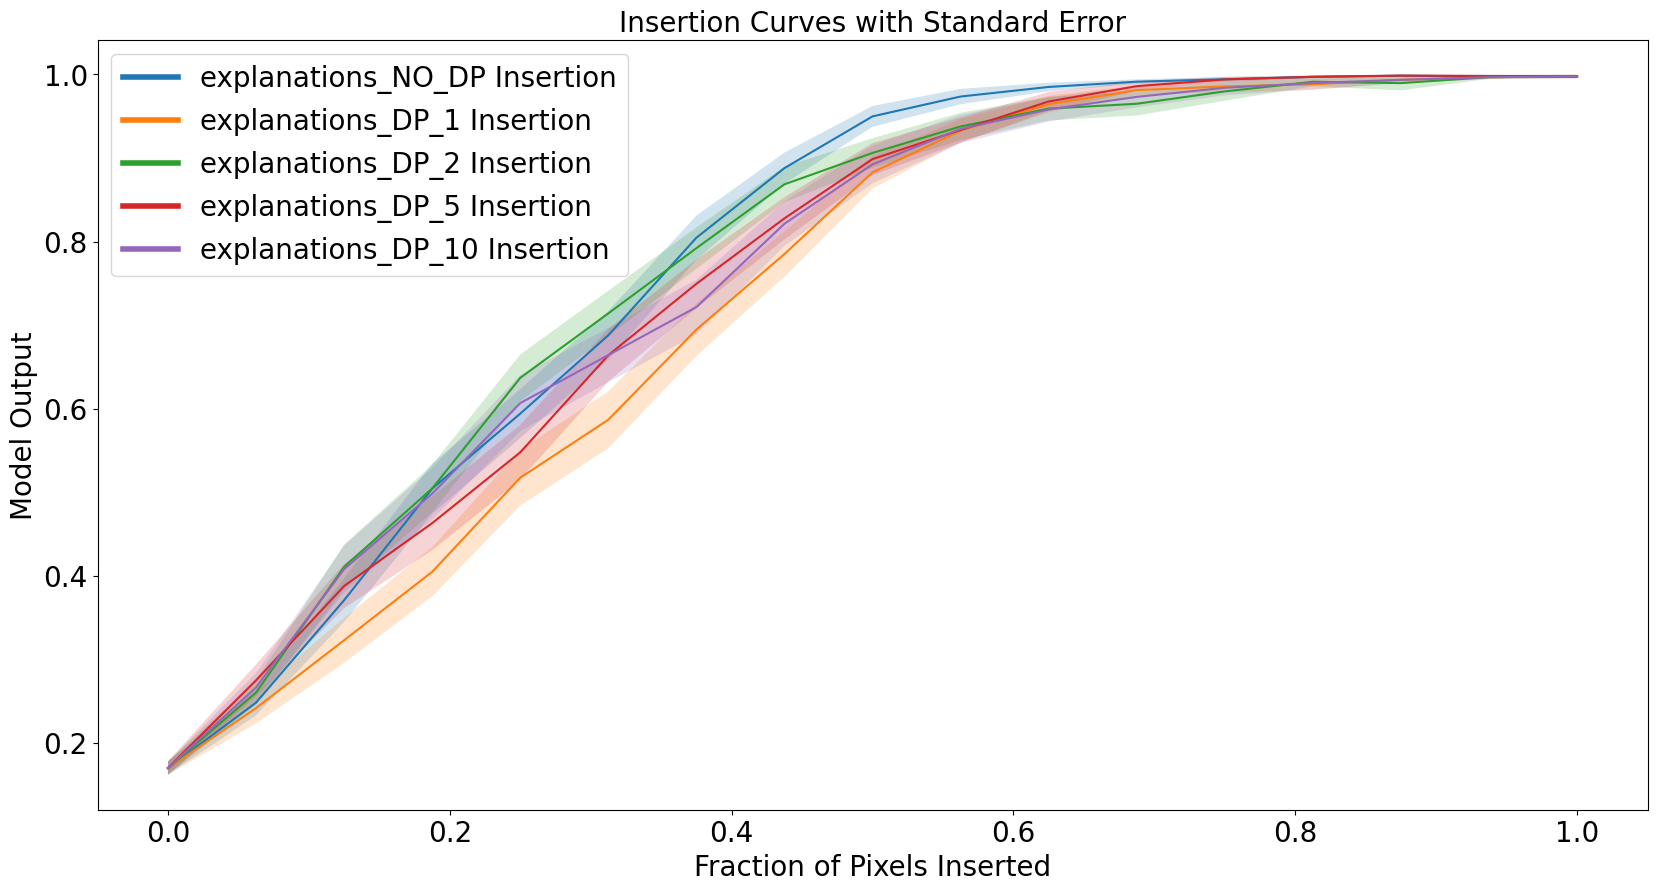

In [41]:
# Define the x values for the plot

plt.figure(figsize=(20, 10))

# Plot each curve in the insert_dict dictionary
for key in insert_dict.keys():
    if "std" not in key:
        print(key)
        x_values = [
            i / (len(insert_dict[key]) - 1) for i in range(len(insert_dict[key]))
        ]

        plt.plot(x_values, insert_dict[key], label=f"{key} Insertion")
        plt.fill_between(
            x_values,
            insert_dict[key] - insert_dict[key + "_std"],
            insert_dict[key] + insert_dict[key + "_std"],
            alpha=0.2,
        )

# font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Fraction of Pixels Inserted", fontsize=20)
plt.ylabel("Model Output", fontsize=20)
plt.title("Insertion Curves with Standard Error", fontsize=20)
leg = plt.legend(fontsize=20)
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.show()

explanations_NO_DP
explanations_DP_1
explanations_DP_2
explanations_DP_5
explanations_DP_10


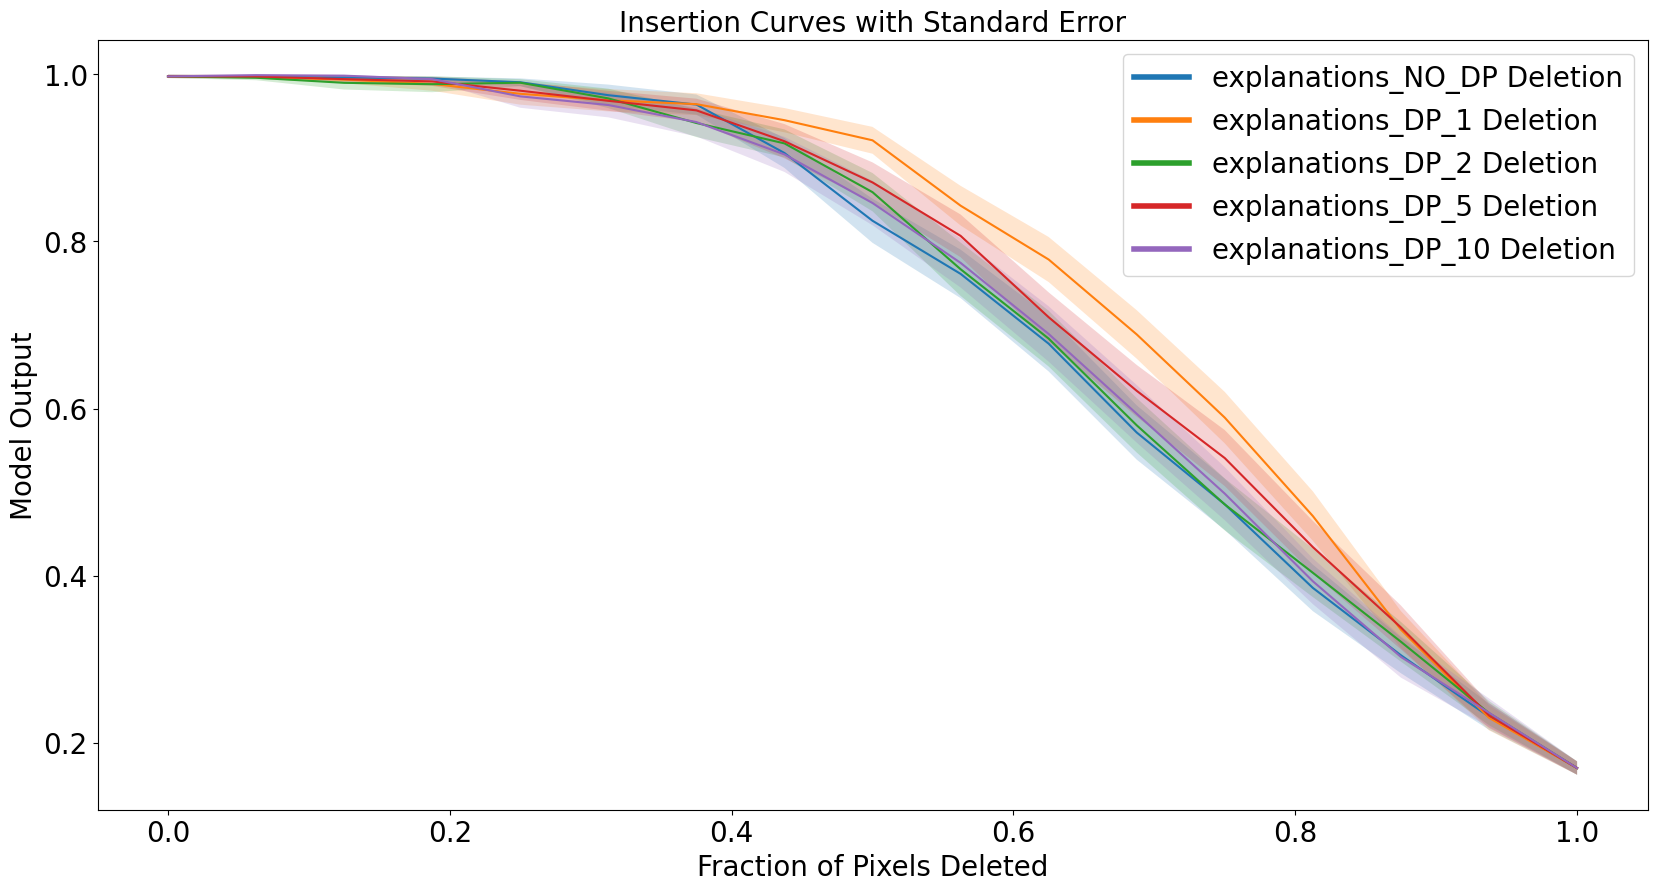

In [42]:
# Define the x values for the plot

plt.figure(figsize=(20, 10))

# Plot each curve in the insert_dict dictionary
for key in delete_dict.keys():
    if "std" not in key:
        print(key)
        x_values = [
            i / (len(delete_dict[key]) - 1) for i in range(len(delete_dict[key]))
        ]

        plt.plot(x_values, delete_dict[key], label=f"{key} Deletion")
        plt.fill_between(
            x_values,
            delete_dict[key] - delete_dict[key + "_std"],
            delete_dict[key] + delete_dict[key + "_std"],
            alpha=0.2,
        )
# font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Fraction of Pixels Deleted", fontsize=20)
plt.ylabel("Model Output", fontsize=20)
plt.title("Insertion Curves with Standard Error", fontsize=20)
leg = plt.legend(fontsize=20)
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.show()

In [43]:
loaded_data_NO_DP_bb.keys()

dict_keys(['private_model', 'private_surrogate', 'model', 'model_aix', 'surrogate', 'explainer_NO_DP', 'explainer_DP_1', 'explainer_DP_2', 'explainer_DP_5', 'explainer_DP_10', 'model_predictions', 'explanations_NO_DP', 'faithfulness_NO_DP', 'explanations_DP_1', 'faithfulness_DP_1', 'explanations_DP_2', 'faithfulness_DP_2', 'explanations_DP_5', 'faithfulness_DP_5', 'explanations_DP_10', 'faithfulness_DP_10'])

In [44]:
np.mean(insertion, axis=0)

NameError: name 'insertion' is not defined

In [ ]:
ins_del = ImageInsDel(
    predict=loaded_data_NO_DP_bb["model"],
    mode="del",
    step=50,
    # return the blurred image
    substrate_fn=lambda z: torch.tensor(gaussian_filter(z, sigma=10)),
)
# repeat each element in explanation two times
new_explanation = np.repeat(explanation, 2, axis=0)
new_explanation = np.repeat(new_explanation, 2, axis=1)
print(new_explanation.shape)
ins_del(x, 28, new_explanation, rgb=False, verbose=1)

## Plots for explainer trained on NON Private BB

In [ ]:
results_mean, result_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "L2_"
)

In [ ]:
spearman_mean, spearman_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "spearman_"
)

In [ ]:
cosine_mean, cosine_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "cosine_"
)

In [ ]:
kendaltau_mean, kendaltau_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "kendall_"
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(results_mean.keys()),
    results_mean=results_mean,
    results_std=result_std,
    y_label="Mean Distance",
    title="Mean Distance with Standard Deviation for Different Epsilon Values",
    y_lim=(0.08, 0.25),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(spearman_mean.keys()),
    results_mean=spearman_mean,
    results_std=spearman_std,
    y_label="Correlation",
    title="Spearman correlation with Standard Deviation for Different Epsilon Values",
    y_lim=(-0.25, 0.75),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(cosine_mean.keys()),
    results_mean=cosine_mean,
    results_std=cosine_std,
    y_label="Similarity",
    title="Cosine Similarity with Standard Deviation for Different Epsilon Values",
    y_lim=(-1, 1),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(kendaltau_mean.keys()),
    results_mean=kendaltau_mean,
    results_std=kendaltau_std,
    y_label="Kendaltau",
    title="Kendaltau with Standard Deviation for Different Epsilon Values",
    y_lim=(-1, 1),
)

## Plots for explainer trained on Private BB

In [ ]:
# results_mean_private, result_std_private = create_dictionaries_metrics(
#     explainer_privacy_levels[1:], metrics_private_BB, "L2_"
# )

In [ ]:
# spearman_mean_private, spearman_std_private = create_dictionaries_metrics(
#     explainer_privacy_levels[1:], metrics_private_BB, "spearman_"
# )

In [ ]:
# cosine_mean_private, cosine_std_private = create_dictionaries_metrics(
#     explainer_privacy_levels[1:], metrics_private_BB, "cosine_"
# )

In [ ]:
# kendaltau_mean_private, kendaltau_std_private = create_dictionaries_metrics(
#     explainer_privacy_levels[1:], metrics_private_BB, "kendall_"
# )

In [ ]:
# del results_mean_private["Epsilon 5"]
# del results_mean_private["Epsilon 10"]

# del spearman_mean_private["Epsilon 5"]
# del spearman_mean_private["Epsilon 10"]

# del cosine_mean_private["Epsilon 5"]
# del cosine_mean_private["Epsilon 10"]

# del kendaltau_mean_private["Epsilon 5"]
# del kendaltau_mean_private["Epsilon 10"]

In [ ]:
# plot_error_bar(  # Extracting the means and standard errors
#     labels=list(results_mean_private.keys()),
#     results_mean=results_mean_private,
#     results_std=result_std_private,
#     y_label="Mean Distance",
#     title="Mean Distance with Standard Deviation for Different Epsilon Values - Private BB",
#     y_lim=(0.08, 0.25),
# )

In [ ]:
# plot_error_bar(  # Extracting the means and standard errors
#     labels=list(spearman_mean_private.keys()),
#     results_mean=spearman_mean_private,
#     results_std=spearman_std_private,
#     y_label="Correlation",
#     title="Spearman correlation with Standard Deviation for Different Epsilon Values - Private BB",
#     y_lim=(-0.25, 0.75),
# )

In [ ]:
# plot_error_bar(  # Extracting the means and standard errors
#     labels=list(cosine_mean.keys()),
#     results_mean=cosine_mean_private,
#     results_std=cosine_std_private,
#     y_label="Similarity",
#     title="Cosine Similarity with Standard Deviation for Different Epsilon Values - Private BB",
#     y_lim=(-1, 1),
# )

In [ ]:
# plot_error_bar(  # Extracting the means and standard errors
#     labels=list(kendaltau_mean.keys()),
#     results_mean=kendaltau_mean_private,
#     results_std=kendaltau_std_private,
#     y_label="Kendaltau",
#     title="Kendaltau with Standard Deviation for Different Epsilon Values - Private BB",
#     y_lim=(-1, 1),
# )